# Imports

In [43]:
import sys
# !{sys.executable} -m pip install -r requirements.txt

In [44]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import evaluationutils

In [45]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Configurations

In [46]:
params = {
    "im2vec_file": "./siamese_network_results.csv",
    "pyradiomics_file": "./segmentation_results.csv",
    "modules": ['crossval', 'XGBoost', 'kNN', 'randomforest'], #['tSNE']
    "seed": 14
}

In [47]:
# Seed
np.random.seed(params["seed"])

# Get image Embeddings

In [48]:
df_embeddings = pd.read_csv(params["im2vec_file"], sep = ',', converters={"class_anchor": lambda x: x.strip("[]' ,").replace("'","").split(", ")})
df_embeddings

,Anchor,class_anchor,patient_id,age,projection,0,1,2,3,4,...,517,518,519,520,521,522,523,524,525,526
0,10001.png,[normal],NaN,1.0,NaN,0.114415,-0.000384,-0.045945,-0.689675,0.074424,...,0.000406,0.000394,0.000381,0.000722,0.000436,0.029501,0.000436,0.000414,0.000401,0.000436
1,10002.png,[normal],NaN,4.0,NaN,0.161416,0.117186,0.079933,-0.689472,0.123091,...,0.000394,0.000382,0.000369,0.000723,0.000425,0.014500,0.000423,0.000402,0.000388,0.000425
2,10003.png,[normal],NaN,11.0,NaN,0.440090,-0.071779,-0.005180,-0.585554,0.302895,...,0.000425,0.000414,0.000402,0.000709,0.000453,0.106709,0.000456,0.000432,0.000420,0.000452
3,10004.png,[normal],NaN,0.0,NaN,0.199513,0.236111,0.138952,-0.607385,0.068279,...,0.000412,0.000400,0.000387,0.000727,0.000442,0.032948,0.000442,0.000420,0.000407,0.000442
4,10005.png,[normal],NaN,2.0,NaN,0.129760,0.011995,-0.030717,-0.662310,0.089031,...,0.000409,0.000398,0.000385,0.000713,0.000438,0.045341,0.000440,0.000417,0.000404,0.000438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,50496.png,[tumor(s)],NaN,43.0,NaN,-0.054664,0.006316,-0.078433,-0.403447,0.084872,...,0.000406,0.000394,0.000381,0.000739,0.000438,0.016468,0.000437,0.000415,0.000401,0.000438
2154,50497.png,[tumor(s)],NaN,32.0,NaN,-0.063231,-0.169365,-0.024540,-0.379094,0.110462,...,0.000406,0.000394,0.000381,0.000728,0.000437,0.022816,0.000436,0.000414,0.000400,0.000436
2155,50498.png,[tumor(s)],NaN,38.0,NaN,0.420875,0.009254,-0.171295,-0.415959,0.128509,...,0.000416,0.000405,0.000392,0.000724,0.000446,0.045377,0.000447,0.000424,0.000411,0.000446
2156,50499.png,[tumor(s)],NaN,41.0,NaN,0.090890,0.093846,-0.117923,-0.465891,0.090001,...,0.000396,0.000384,0.000371,0.000723,0.000427,0.016110,0.000426,0.000405,0.000391,0.000427


# PyRadiomic features from segmentation masks

In [49]:
df_pyradiomics = pd.read_csv(params["pyradiomics_file"], sep = ',')
df_pyradiomics

,Anchor,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,...,diagnostics_Mask-original_CenterOfMassIndex_1,diagnostics_Mask-original_CenterOfMass_0,diagnostics_Mask-original_CenterOfMass_1,diagnostics_Image-original_Size_0,diagnostics_Image-original_Size_1,diagnostics_Image-original_Size_2,diagnostics_Mask-original_Spacing_0,diagnostics_Mask-original_Spacing_1,diagnostics_Mask-original_Size_0,diagnostics_Mask-original_Size_1
0,10001.png,3643.730799,0.0,16383.0,146995,4,0.489928,171.803021,140.9372,124.4544,...,449.692194,95.386521,83.282994,1093,933,1,0.1852,0.1852,1093,933
1,10002.png,5020.519682,0.0,16383.0,371548,4,0.646898,231.432628,184.4808,126.2736,...,473.640316,128.721183,89.802204,1305,1137,1,0.1896,0.1896,1305,1137
2,10003.png,1788.379015,1.0,4082.0,1497820,3,0.720892,313.900836,253.6720,197.4320,...,951.722451,167.579316,140.854923,2278,2061,1,0.1480,0.1480,2278,2061
3,10004.png,5606.361342,0.0,16383.0,136861,5,0.586460,153.657134,138.7148,68.8944,...,365.727687,94.583378,67.732768,1014,801,1,0.1852,0.1852,1014,801
4,10005.png,2806.019062,0.0,16383.0,228130,2,0.523663,207.943838,163.3464,89.0812,...,447.498422,97.495622,82.876708,1057,946,1,0.1852,0.1852,1057,946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,50482.png,566.375375,0.0,1023.0,1873074,2,0.762894,328.755683,259.8310,231.9460,...,1086.864444,155.905923,155.421616,2244,2652,1,0.1430,0.1430,2244,2652
2065,50483.png,545.424717,0.0,1023.0,1848472,2,0.677131,349.154369,285.1420,200.0570,...,1103.668330,205.968190,157.824571,2997,2797,1,0.1430,0.1430,2997,2797
2066,50484.png,612.332757,0.0,1023.0,2143555,2,0.618238,406.744610,341.3410,219.5050,...,1217.310802,197.860223,174.075445,2822,2977,1,0.1430,0.1430,2822,2977
2067,50485.png,543.799692,0.0,1023.0,1790211,4,0.648517,339.546090,272.9870,228.6570,...,1094.840549,203.279836,156.562199,3000,2961,1,0.1430,0.1430,3000,2961


# Divide data to X and y

In [50]:
X = df_embeddings.drop(df_embeddings.columns[0], axis=1, inplace =False)
X = X.to_numpy()

mlb = MultiLabelBinarizer(sparse_output=True)

X = df_embeddings.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_embeddings['class_anchor']),
                index=df_embeddings.index,
                columns=mlb.classes_).add_prefix('class_'))

X.head()

,Anchor,class_anchor,patient_id,age,projection,0,1,2,3,4,...,523,524,525,526,class_cardiomegaly,class_emphysema,class_fluid,class_normal,class_thickening,class_tumor(s)
0,10001.png,[normal],NaN,1.0,NaN,0.114415,-0.000384,-0.045945,-0.689675,0.074424,...,0.000436,0.000414,0.000401,0.000436,0,0,0,1,0,0
1,10002.png,[normal],NaN,4.0,NaN,0.161416,0.117186,0.079933,-0.689472,0.123091,...,0.000423,0.000402,0.000388,0.000425,0,0,0,1,0,0
2,10003.png,[normal],NaN,11.0,NaN,0.440090,-0.071779,-0.005180,-0.585554,0.302895,...,0.000456,0.000432,0.000420,0.000452,0,0,0,1,0,0
3,10004.png,[normal],NaN,0.0,NaN,0.199513,0.236111,0.138952,-0.607385,0.068279,...,0.000442,0.000420,0.000407,0.000442,0,0,0,1,0,0
4,10005.png,[normal],NaN,2.0,NaN,0.129760,0.011995,-0.030717,-0.662310,0.089031,...,0.000440,0.000417,0.000404,0.000438,0,0,0,1,0,0


In [51]:
X.columns = [int(i) if str(i).isnumeric() else i for i in X.columns]

y = pd.DataFrame( X['class_anchor'].apply(lambda x: ','.join(map(str, x))), columns=['class_anchor'])
y['bin'] =  y.rank(method='dense').astype(int) -1
y['Anchor'] = X.loc[:, 'Anchor']

In [52]:
y

,class_anchor,bin,Anchor
0,normal,3,10001.png
1,normal,3,10002.png
2,normal,3,10003.png
3,normal,3,10004.png
4,normal,3,10005.png
...,...,...,...
2153,tumor(s),5,50496.png
2154,tumor(s),5,50497.png
2155,tumor(s),5,50498.png
2156,tumor(s),5,50499.png


In [53]:
print(np.sort(pd.unique(y['bin'])))

[0 1 2 3 4 5]


## Combine image embeddings and tabular data

In [54]:
anchor = X.loc[:, 'Anchor']
emb = X.loc[:, 0:max([i for i in X.columns if isinstance(i, int) or i.isnumeric()])]
tabul = X.loc[:, 'age']
X = pd.concat([anchor, emb, tabul], axis=1)
del anchor, emb, tabul

## Combine image embeddings and tabular data with Pyradiomics features

In [55]:
removal_list = list(set(X.Anchor.to_list()) - set(df_pyradiomics.Anchor.to_list()))

y = y[~y['Anchor'].isin(removal_list)]
y.drop(['Anchor'], inplace=True, axis=1)

X = pd.merge(X, df_pyradiomics, on="Anchor")
df_enc = X.copy()
X.drop(['Anchor'], inplace=True, axis=1)

del removal_list

<ipython-input-55-8c9ffabed511>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(['Anchor'], inplace=True, axis=1)


In [56]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,diagnostics_Mask-original_CenterOfMassIndex_1,diagnostics_Mask-original_CenterOfMass_0,diagnostics_Mask-original_CenterOfMass_1,diagnostics_Image-original_Size_0,diagnostics_Image-original_Size_1,diagnostics_Image-original_Size_2,diagnostics_Mask-original_Spacing_0,diagnostics_Mask-original_Spacing_1,diagnostics_Mask-original_Size_0,diagnostics_Mask-original_Size_1
0,0.114415,-0.000384,-0.045945,-0.689675,0.074424,-0.019164,-0.236524,0.519167,0.035036,0.513395,...,449.692194,95.386521,83.282994,1093,933,1,0.1852,0.1852,1093,933
1,0.161416,0.117186,0.079933,-0.689472,0.123091,0.064160,-0.290021,0.373386,-0.008939,0.487495,...,473.640316,128.721183,89.802204,1305,1137,1,0.1896,0.1896,1305,1137
2,0.440090,-0.071779,-0.005180,-0.585554,0.302895,0.020642,-0.275552,0.256461,-0.212354,0.396841,...,951.722451,167.579316,140.854923,2278,2061,1,0.1480,0.1480,2278,2061
3,0.199513,0.236111,0.138952,-0.607385,0.068279,0.093380,-0.076792,0.354622,0.123941,0.568928,...,365.727687,94.583378,67.732768,1014,801,1,0.1852,0.1852,1014,801
4,0.129760,0.011995,-0.030717,-0.662310,0.089031,0.062323,-0.135343,0.454197,-0.037710,0.467546,...,447.498422,97.495622,82.876708,1057,946,1,0.1852,0.1852,1057,946


## Fix faulty data

In [57]:
# remove NaN
X[X.isna().any(axis=1)]
X = X.interpolate(method='nearest')

## Scale data

In [58]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X

,0,1,2,3,4,5,6,7,8,9,...,diagnostics_Mask-original_CenterOfMassIndex_1,diagnostics_Mask-original_CenterOfMass_0,diagnostics_Mask-original_CenterOfMass_1,diagnostics_Image-original_Size_0,diagnostics_Image-original_Size_1,diagnostics_Image-original_Size_2,diagnostics_Mask-original_Spacing_0,diagnostics_Mask-original_Spacing_1,diagnostics_Mask-original_Size_0,diagnostics_Mask-original_Size_1
0,0.445674,0.417668,0.423011,0.272445,0.511296,0.466862,0.335663,0.823117,0.470339,0.764413,...,0.062717,0.162219,0.096674,0.099287,0.091385,0.0,0.852,0.852,0.099287,0.091385
1,0.497759,0.546626,0.610269,0.272727,0.564420,0.573144,0.250259,0.577253,0.404620,0.732422,...,0.072330,0.289820,0.116059,0.159772,0.147536,0.0,0.896,0.896,0.159772,0.147536
2,0.806572,0.339357,0.483655,0.416678,0.760690,0.517636,0.273357,0.380053,0.100629,0.620446,...,0.264232,0.438563,0.267863,0.437375,0.401872,0.0,0.480,0.480,0.437375,0.401872
3,0.539976,0.677071,0.698067,0.386437,0.504587,0.610416,0.590669,0.545606,0.603202,0.833008,...,0.029014,0.159145,0.050436,0.076748,0.055051,0.0,0.852,0.852,0.076748,0.055051
4,0.462679,0.431247,0.445664,0.310352,0.527240,0.570800,0.497194,0.713543,0.361624,0.707781,...,0.061837,0.170292,0.095466,0.089016,0.094963,0.0,0.852,0.852,0.089016,0.094963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,0.462742,0.560862,0.151230,0.519455,0.560444,0.209963,0.626756,0.562979,0.200749,0.544188,...,0.318478,0.393879,0.311177,0.427675,0.564547,0.0,0.430,0.430,0.427675,0.564547
2065,0.464625,0.596386,0.407403,0.457265,0.479090,0.465309,0.294357,0.482750,0.112718,0.610423,...,0.325223,0.585511,0.318322,0.642511,0.604459,0.0,0.430,0.430,0.642511,0.604459
2066,0.372699,0.616841,0.361393,0.561943,0.260020,0.505874,0.404501,0.425958,0.651564,0.614966,...,0.370839,0.554475,0.366644,0.592582,0.654005,0.0,0.430,0.430,0.592582,0.654005
2067,0.414256,0.328369,0.286195,0.702164,0.367848,0.409402,0.453983,0.357500,0.478035,0.444881,...,0.321680,0.575220,0.314569,0.643367,0.649601,0.0,0.430,0.430,0.643367,0.649601


## Divide to train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=params["seed"])

X_train=np.reshape(X_train, X_train.shape, order='C').to_numpy()
X_train = np.ascontiguousarray(X_train)

y_train=np.reshape(y_train, y_train.shape, order='C').to_numpy()
y_train = np.ascontiguousarray(y_train)

X_test=np.reshape(X_test, X_test.shape, order='C').to_numpy()
X_test = np.ascontiguousarray(X_test)

In [60]:
if 'crossval' in params['modules']:
    X_all = np.reshape(X, X.shape, order='C').to_numpy()
    X_all = np.ascontiguousarray(X)

    y_all =np.reshape(y, y.shape, order='C').to_numpy()
    y_all = np.ascontiguousarray(y)

# Train models

KNN
Hamming loss on test data: 0.622
Accuracy on test data: 0.378
              precision    recall  f1-score   support

cardiomegaly      0.346     0.547     0.423        86
   emphysema      0.347     0.340     0.343       103
       fluid      0.333     0.143     0.200        28
      normal      0.396     0.546     0.459        97
  thickening      0.382     0.312     0.343        93
    tumor(s)      0.475     0.252     0.329       111

    accuracy                          0.378       518
   macro avg      0.380     0.357     0.350       518
weighted avg      0.389     0.378     0.367       518



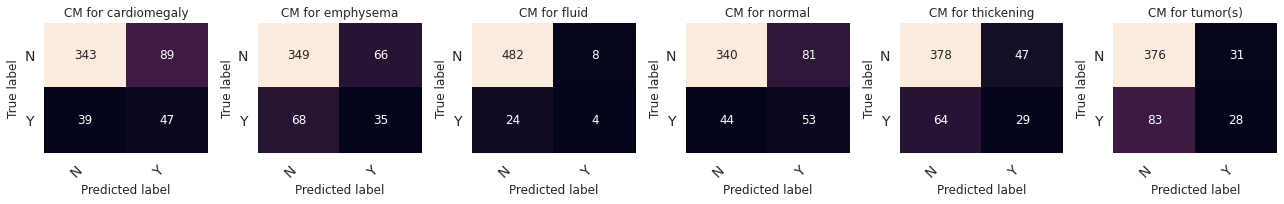

In [61]:
if 'kNN' in params["modules"]:

    classifier = KNeighborsClassifier(n_neighbors=3)


    classifier = classifier.fit(X_train, y_train[:, 1].astype('int'))
    joblib.dump(classifier, 'model_kNN.json')

    prediction = classifier.predict(X_test)

    evaluationutils.evaluate(y_test['bin'], prediction, np.sort(pd.unique(y['class_anchor'])), 'KNN') #y.columns

In [62]:
if 'crossval' in params['modules'] and 'kNN' in params["modules"]:
    scoring = ['accuracy', 'balanced_accuracy', 
    'f1_macro', 'f1_micro', 'f1_weighted', 
    'precision_macro', 'precision_micro', 'precision_weighted', 
    'recall_macro', 'recall_micro', 'recall_weighted', 
    'roc_auc_ovr', 'roc_auc_ovr_weighted', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 
    'jaccard_macro', 'jaccard_micro', 'jaccard_weighted']
    scores = cross_validate(classifier, X_all, y_all[:, 1].astype('int'), cv=5, scoring=scoring, return_train_score=True)
    for i in scores:
        if i.startswith('test'):
            print("{:.3f} \t {} \t\t\t with a standard deviation of \t{:.3f}".format(scores[i].mean(), i, scores[i].std()))

0.335 	 test_accuracy 			 with a standard deviation of 	0.041
0.322 	 test_balanced_accuracy 			 with a standard deviation of 	0.036
0.314 	 test_f1_macro 			 with a standard deviation of 	0.045
0.335 	 test_f1_micro 			 with a standard deviation of 	0.041
0.321 	 test_f1_weighted 			 with a standard deviation of 	0.039
0.386 	 test_precision_macro 			 with a standard deviation of 	0.021
0.335 	 test_precision_micro 			 with a standard deviation of 	0.041
0.375 	 test_precision_weighted 			 with a standard deviation of 	0.029
0.322 	 test_recall_macro 			 with a standard deviation of 	0.036
0.335 	 test_recall_micro 			 with a standard deviation of 	0.041
0.335 	 test_recall_weighted 			 with a standard deviation of 	0.041
0.662 	 test_roc_auc_ovr 			 with a standard deviation of 	0.024
0.651 	 test_roc_auc_ovr_weighted 			 with a standard deviation of 	0.026
0.663 	 test_roc_auc_ovo 			 with a standard deviation of 	0.024
0.658 	 test_roc_auc_ovo_weighted 			 with a standard deviation

[11:26:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost
Hamming loss on test data: 0.539
Accuracy on test data: 0.461
              precision    recall  f1-score   support

cardiomegaly      0.451     0.593     0.513        86
   emphysema      0.406     0.272     0.326       103
       fluid      0.333     0.214     0.261        28
      normal      0.549     0.691     0.612        97
  thickening      0.395     0.344     0.368        93
    tumor(s)      0.478     0.495     0.487       111

    accuracy                          0.461       518
   macro avg      0.435     0.435     0.428       518
weighted avg      0.450     0.461     0.449       518



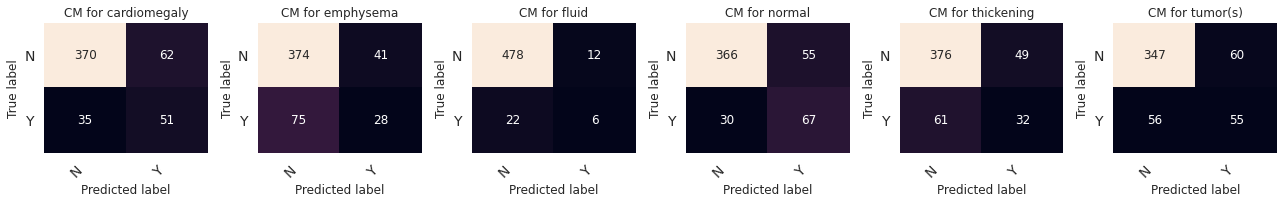

In [63]:
if 'XGBoost' in params["modules"]:

    xgb_estimator = xgb.XGBClassifier(objective='multi:softprob')

    xgb_estimator.fit(X_train, y_train[:, 1].astype('int'))
    xgb_estimator.save_model('model_xgb_estimator.json')

    prediction2 = xgb_estimator.predict(X_test)

    evaluationutils.evaluate(y_test['bin'], prediction2, np.sort(pd.unique(y['class_anchor'])), 'XGBoost') #y.columns

In [64]:
if 'crossval' in params['modules'] and 'XGBoost' in params["modules"]:
    scoring = ['accuracy', 'balanced_accuracy', 
    'f1_macro', 'f1_micro', 'f1_weighted', 
    'precision_macro', 'precision_micro', 'precision_weighted', 
    'recall_macro', 'recall_micro', 'recall_weighted', 
    'roc_auc_ovr', 'roc_auc_ovr_weighted', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 
    'jaccard_macro', 'jaccard_micro', 'jaccard_weighted']
    scores = cross_validate(xgb_estimator, X_all, y_all[:, 1].astype('int'), cv=5, scoring=scoring, return_train_score=True)
    for i in scores:
        if i.startswith('test'):
            print("{:.3f} \t {} \t\t\t with a standard deviation of \t{:.3f}".format(scores[i].mean(), i, scores[i].std()))

[11:27:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

random forest
Hamming loss on test data: 0.556
Accuracy on test data: 0.444
              precision    recall  f1-score   support

cardiomegaly      0.417     0.558     0.478        86
   emphysema      0.430     0.330     0.374       103
       fluid      0.571     0.143     0.229        28
      normal      0.500     0.660     0.569        97
  thickening      0.398     0.462     0.428        93
    tumor(s)      0.457     0.333     0.385       111

    accuracy                          0.444       518
   macro avg      0.462     0.414     0.410       518
weighted avg      0.449     0.444     0.432       518



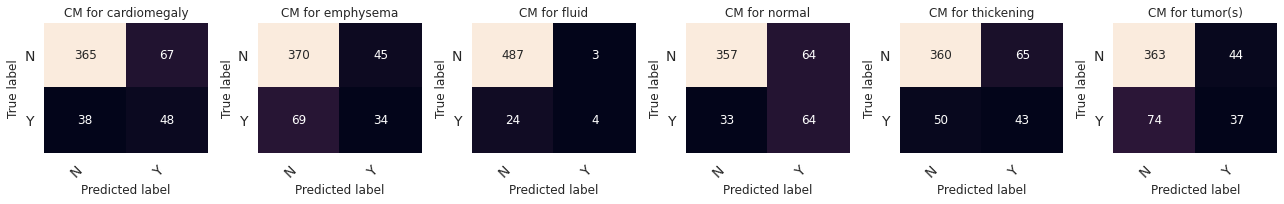

In [65]:
if 'randomforest' in params['modules']:

    clf = RandomForestClassifier()
    
    clf.fit(X_train, y_train[:, 1].astype('int'))
    joblib.dump(clf, 'model_RandomForest.json')

    prediction3 = clf.predict(X_test)

    evaluationutils.evaluate(y_test['bin'], prediction3, np.sort(pd.unique(y['class_anchor'])), 'random forest') #y.columns

In [66]:
if 'crossval' in params['modules'] and 'randomforest' in params['modules']:
    scoring = ['accuracy', 'balanced_accuracy', 
    'f1_macro', 'f1_micro', 'f1_weighted', 
    'precision_macro', 'precision_micro', 'precision_weighted', 
    'recall_macro', 'recall_micro', 'recall_weighted', 
    'roc_auc_ovr', 'roc_auc_ovr_weighted', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 
    'jaccard_macro', 'jaccard_micro', 'jaccard_weighted']
    scores = cross_validate(clf, X_all, y_all[:, 1].astype('int'), cv=5, scoring=scoring, return_train_score=True)
    for i in scores:
        if i.startswith('test'):
            print("{:.3f} \t {} \t\t\t with a standard deviation of \t{:.3f}".format(scores[i].mean(), i, scores[i].std()))

0.353 	 test_accuracy 			 with a standard deviation of 	0.065
0.332 	 test_balanced_accuracy 			 with a standard deviation of 	0.024
0.306 	 test_f1_macro 			 with a standard deviation of 	0.039
0.353 	 test_f1_micro 			 with a standard deviation of 	0.065
0.342 	 test_f1_weighted 			 with a standard deviation of 	0.047
0.391 	 test_precision_macro 			 with a standard deviation of 	0.087
0.353 	 test_precision_micro 			 with a standard deviation of 	0.065
0.410 	 test_precision_weighted 			 with a standard deviation of 	0.069
0.332 	 test_recall_macro 			 with a standard deviation of 	0.024
0.353 	 test_recall_micro 			 with a standard deviation of 	0.065
0.353 	 test_recall_weighted 			 with a standard deviation of 	0.065
0.761 	 test_roc_auc_ovr 			 with a standard deviation of 	0.030
0.737 	 test_roc_auc_ovr_weighted 			 with a standard deviation of 	0.022
0.762 	 test_roc_auc_ovo 			 with a standard deviation of 	0.031
0.752 	 test_roc_auc_ovo_weighted 			 with a standard deviation